# Assignment for Machine Learning and AI from IIIT Bangalore | Upgrad

#### Developed by:
##### 1. Pragadeesh S - Group Member
##### 2. Vicky Bachu - Group Facilitator

#### Batch: ML C36


## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [2]:
# Importing libraries

import numpy as np
import os
import PIL
from PIL import Image, ImageFilter
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import cv2
from cv2 import imread
from cv2 import resize as imresize
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [39]:
# importing libraries required for model building.
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Bidirectional, SimpleRNN, RNN, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from tensorflow.keras.layers import LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, AveragePooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

In [5]:
project_folder=r"C:\Users\sprag\Documents\PG-AIML\Gesture Recognition\Project_data"
train_doc = np.random.permutation(open(r"C:\Users\sprag\Documents\PG-AIML\Gesture Recognition\Project_data\train.csv").readlines())
val_doc = np.random.permutation(open(r"C:\Users\sprag\Documents\PG-AIML\Gesture Recognition\Project_data\val.csv").readlines())
batch_size = 64 #experiment with the batch size
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 160, 160

In [6]:
sample_image = os.listdir(project_folder+'/train/'+ np.random.permutation(train_doc)[0 + (0)].split(';')[0])

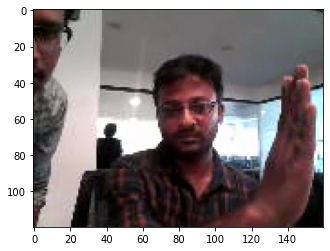

In [7]:
sample_im_path = project_folder+'/train/'+ train_doc[0].split(';')[0]
sample = imread(sample_im_path+'/'+os.listdir(sample_im_path)[0])
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
plt.imshow(sample)

In [8]:
sample.shape

(120, 160, 3)

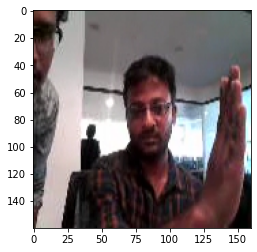

In [9]:
sample = imresize(sample,(dim_x, dim_y))
plt.imshow(sample)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),dim_x,dim_y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(dim_x, dim_y))
                   
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),dim_x,dim_y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    image = imresize(image,(dim_x, dim_y))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
            

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = r"C:\Users\sprag\Documents\PG-AIML\Gesture Recognition\Project_data\train"
val_path = r"C:\Users\sprag\Documents\PG-AIML\Gesture Recognition\Project_data\val"


num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 16 # choose the number of epochs
print ('# epochs =', num_epochs)

num_classes = 5
input_shape = (len(seq_idx), dim_x, dim_y, 3)

# training sequences = 663
# validation sequences = 100
# epochs = 16


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model Build 1:

In [14]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:
# compile it
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 8, 158, 158, 32)   2624      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 79, 79, 32)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 2, 77, 77, 64)     55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 1, 38, 38, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 92416)             0         
                                                                 
 dense (Dense)               (None, 256)              

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
model_name = 'Gesture_recognition' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
#LR = # write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
callbacks_list = [checkpoint]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:\Users\sprag\Documents\PG-AIML\Gesture Recognition\Project_data\train ; batch size = 64
Epoch 1/16
11/11 [==============================] - ETA: 0s - loss: 3.0554 - categorical_accuracy: 0.2187 Source path =  C:\Users\sprag\Documents\PG-AIML\Gesture Recognition\Project_data\val ; batch size = 64

Epoch 1: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00001-3.05545-0.21870-1.56121-0.24000.h5
11/11 [==============================] - 464s 42s/step - loss: 3.0554 - categorical_accuracy: 0.2187 - val_loss: 1.5612 - val_categorical_accuracy: 0.2400
Epoch 2/16
11/11 [==============================] - ETA: 0s - loss: 1.4906 - categorical_accuracy: 0.3243 
Epoch 2: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00002-1.49057-0.32428-1.57155-0.22000.h5
11/11 [==============================] - 455s 41s/step - loss: 1.4906 - categorical_accuracy: 0.3243 - val_loss: 1.5716 - val_categorical_accuracy: 0.2200
Epoch 3/16
11/11 [==============

## Model Build 2:

In [20]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [21]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 8, 158, 158, 32)   2624      
                                                                 
 conv3d_7 (Conv3D)           (None, 6, 156, 156, 64)   55360     
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 3, 78, 78, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 3, 78, 78, 64)    256       
 hNormalization)                                                 
                                                                 
 conv3d_8 (Conv3D)           (None, 1, 76, 76, 128)    221312    
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 1, 38, 38, 128)  

In [22]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/16
11/11 [==============================] - ETA: 0s - loss: 2.3038 - categorical_accuracy: 0.5264  
Epoch 1: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00001-2.30380-0.52640-34.91789-0.23000.h5
11/11 [==============================] - 1282s 116s/step - loss: 2.3038 - categorical_accuracy: 0.5264 - val_loss: 34.9179 - val_categorical_accuracy: 0.2300
Epoch 2/16
11/11 [==============================] - ETA: 0s - loss: 0.7070 - categorical_accuracy: 0.7798  
Epoch 2: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00002-0.70703-0.77979-8.74665-0.27000.h5
11/11 [==============================] - 1181s 107s/step - loss: 0.7070 - categorical_accuracy: 0.7798 - val_loss: 8.7466 - val_categorical_accuracy: 0.2700
Epoch 3/16
11/11 [==============================] - ETA: 0s - loss: 0.3607 - categorical_accuracy: 0.8718  
Epoch 3: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00003-0.36066-0.87179-4.91886-0.25000.h5
11/11 

## Model build 3:
Conv3D + Droupouts

In [46]:
num_epochs = 16
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [47]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 8, 158, 158, 32)   2624      
                                                                 
 conv3d_13 (Conv3D)          (None, 6, 156, 156, 64)   55360     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 3, 78, 78, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_28 (Bat  (None, 3, 78, 78, 64)    256       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 3, 78, 78, 64)     0         
                                                                 
 conv3d_14 (Conv3D)          (None, 1, 76, 76, 128)  

In [48]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/16
11/11 [==============================] - ETA: 0s - loss: 1.4622 - categorical_accuracy: 0.4510  
Epoch 1: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00001-1.46222-0.45098-1.60559-0.23000.h5
11/11 [==============================] - 1101s 99s/step - loss: 1.4622 - categorical_accuracy: 0.4510 - val_loss: 1.6056 - val_categorical_accuracy: 0.2300
Epoch 2/16
11/11 [==============================] - ETA: 0s - loss: 0.8047 - categorical_accuracy: 0.6531  
Epoch 2: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00002-0.80474-0.65309-1.70088-0.24000.h5
11/11 [==============================] - 1095s 99s/step - loss: 0.8047 - categorical_accuracy: 0.6531 - val_loss: 1.7009 - val_categorical_accuracy: 0.2400
Epoch 3/16
11/11 [==============================] - ETA: 0s - loss: 0.6553 - categorical_accuracy: 0.7451  
Epoch 3: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00003-0.65532-0.74510-1.61284-0.32000.h5
11/11 [===

## Model Build 4:
TimeDistributed Conv2D + GRU

In [30]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [31]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 10, 158, 158, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 10, 79, 79, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_11 (Bat  (None, 10, 79, 79, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 77, 77, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 10, 38, 38, 64)  

In [32]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/16
11/11 [==============================] - ETA: 0s - loss: 1.3946 - categorical_accuracy: 0.4585
Epoch 1: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00001-1.39456-0.45852-1.59973-0.26000.h5
11/11 [==============================] - 67s 6s/step - loss: 1.3946 - categorical_accuracy: 0.4585 - val_loss: 1.5997 - val_categorical_accuracy: 0.2600
Epoch 2/16
11/11 [==============================] - ETA: 0s - loss: 0.9759 - categorical_accuracy: 0.6018
Epoch 2: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00002-0.97592-0.60181-1.59700-0.25000.h5
11/11 [==============================] - 65s 6s/step - loss: 0.9759 - categorical_accuracy: 0.6018 - val_loss: 1.5970 - val_categorical_accuracy: 0.2500
Epoch 3/16
11/11 [==============================] - ETA: 0s - loss: 0.7463 - categorical_accuracy: 0.7255
Epoch 3: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00003-0.74634-0.72549-1.59976-0.21000.h5
11/11 [===============

## Model Build 5:
TimeDistributed Conv2D + Dense

In [35]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(128, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [36]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeDi  (None, 10, 158, 158, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 10, 79, 79, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_18 (Bat  (None, 10, 79, 79, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_19 (TimeDi  (None, 10, 77, 77, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 10, 38, 38, 64)  

In [37]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/16
11/11 [==============================] - ETA: 0s - loss: 1.4319 - categorical_accuracy: 0.4284
Epoch 1: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00001-1.43193-0.42836-1.60822-0.18000.h5
11/11 [==============================] - 78s 7s/step - loss: 1.4319 - categorical_accuracy: 0.4284 - val_loss: 1.6082 - val_categorical_accuracy: 0.1800
Epoch 2/16
11/11 [==============================] - ETA: 0s - loss: 0.8799 - categorical_accuracy: 0.6395
Epoch 2: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00002-0.87992-0.63952-1.64896-0.15000.h5
11/11 [==============================] - 79s 7s/step - loss: 0.8799 - categorical_accuracy: 0.6395 - val_loss: 1.6490 - val_categorical_accuracy: 0.1500
Epoch 3/16
11/11 [==============================] - ETA: 0s - loss: 0.7374 - categorical_accuracy: 0.7104
Epoch 3: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00003-0.73739-0.71041-1.62933-0.18000.h5
11/11 [===============

## Model Build 6:
ConvoLSTM2D

In [40]:
num_epochs = 64
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [41]:
optimiser = optimizers.Adam(lr=0.01) 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_25 (TimeDi  (None, 10, 158, 158, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_24 (Bat  (None, 10, 158, 158, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_26 (TimeDi  (None, 10, 156, 156, 16)  1168     
 stributed)                                                      
                                                                 
 batch_normalization_25 (Bat  (None, 10, 156, 156, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 154, 154, 8)     

In [42]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/64
11/11 [==============================] - ETA: 0s - loss: 1.4489 - categorical_accuracy: 0.3303 
Epoch 1: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00001-1.44887-0.33032-1.68357-0.23000.h5
11/11 [==============================] - 295s 26s/step - loss: 1.4489 - categorical_accuracy: 0.3303 - val_loss: 1.6836 - val_categorical_accuracy: 0.2300
Epoch 2/64
11/11 [==============================] - ETA: 0s - loss: 1.0759 - categorical_accuracy: 0.5068 
Epoch 2: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00002-1.07594-0.50679-1.84871-0.19000.h5
11/11 [==============================] - 305s 28s/step - loss: 1.0759 - categorical_accuracy: 0.5068 - val_loss: 1.8487 - val_categorical_accuracy: 0.1900
Epoch 3/64
11/11 [==============================] - ETA: 0s - loss: 0.9149 - categorical_accuracy: 0.6154 
Epoch 3: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00003-0.91487-0.61538-2.02209-0.18000.h5
11/11 [========

11/11 [==============================] - 341s 31s/step - loss: 0.2022 - categorical_accuracy: 0.9231 - val_loss: 2.8351 - val_categorical_accuracy: 0.2000
Epoch 23/64
11/11 [==============================] - ETA: 0s - loss: 0.2417 - categorical_accuracy: 0.9065 
Epoch 23: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00023-0.24170-0.90649-2.48559-0.38000.h5
11/11 [==============================] - 333s 30s/step - loss: 0.2417 - categorical_accuracy: 0.9065 - val_loss: 2.4856 - val_categorical_accuracy: 0.3800
Epoch 24/64
11/11 [==============================] - ETA: 0s - loss: 0.2272 - categorical_accuracy: 0.9065 
Epoch 24: saving model to Gesture_recognition_2022-08-1709_02_57.921218\model-00024-0.22724-0.90649-3.52583-0.22000.h5
11/11 [==============================] - 306s 28s/step - loss: 0.2272 - categorical_accuracy: 0.9065 - val_loss: 3.5258 - val_categorical_accuracy: 0.2200
Epoch 25/64
11/11 [==============================] - ETA: 0s - loss: 0.2469 - cat

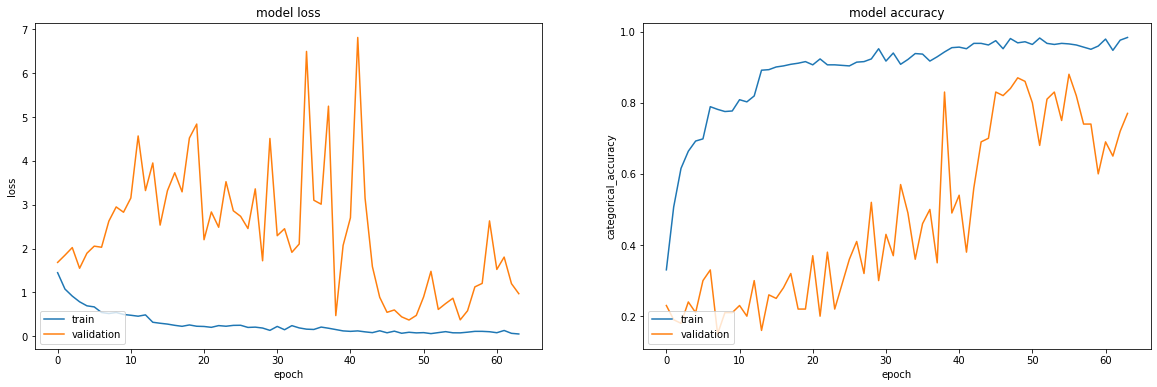

In [43]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')